In [163]:
import os
import re
import pandas as pd

In [164]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [165]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47419

In [166]:
df = df[df['rok'] >= 1900]

In [167]:
df = df.sort_values(by='rok')
df = df.drop_duplicates(subset=['autorstvo','titul'], keep='first')
len(df)

43752

In [168]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how="left")
len(df)

43752

In [169]:
from src.pocet_stran import pocet_stran

In [170]:
def zjisti_cenu(c020):
    c020 = str(c020)
    cena = None
    if 'K' in c020:
        ceny = re.findall(r'\d{1,5},{0,1}\d{0,2}',c020)
        if len(ceny) > 0:
            ceny = [float(c.replace(',','.')) for c in ceny]
            cena = min(ceny)
    if 'hal' in c020:
        ceny = re.findall(r'\d{1,5},{0,1}\d{0,2}',c020)
        if len(ceny) > 0:
            ceny = [float(c.replace(',','.')) for c in ceny]
            cena = max(ceny)
            if cena > 1:
                cena = cena / 100
    return cena

In [171]:
df['cena'] = df['020_c'].apply(lambda x: zjisti_cenu(x))

In [172]:
df[['cena','020_c']].dropna().sample(10)

,cena,020_c
001,,
bk197903105,12.5,"[Kčs 12,50]"
nkc20092006744,317.0,"[Kč 317,00]"
cpk20000970282,189.0,"[Kč 189,00]"
cpk19970100263,120.0,"[Kč 120,00]"
nkc20142650271,269.0,"[Kč 269,00, None]"
cpk20031244983,19.0,"[Kč 19,00]"
cpk20031280366,139.0,"[Kč 139,00]"
cpk20010986531,149.0,"[Kč 149,00]"
cpk20041447128,239.0,"[Kč 239,00]"


In [173]:
df[['cena','020_c']].sort_values(by='cena',ascending=False).head()

,cena,020_c
001,,
ck9005970,1300.0,[Kčs 1300]
nkc20213367361,999.0,"[Kč 999,00]"
nkc20223462298,999.0,"[Kč 999,00]"
nkc20061697735,900.0,"[Kč 900,00, None, None, None, None, None, None]"
nkc20213314569,899.0,"[Kč 899,00]"


In [174]:
df['stran'] = df['300_a'].apply(lambda x: pocet_stran(x))

In [175]:
df[['stran','300_a']].dropna().sample(10)

,stran,300_a
001,,
bk196101183,504.0,[504 s. ;]
nkc20213325532,20.0,[20 nečíslovaných stran :]
bknjaj11350,35.0,[35 s. ;]
nkc20223416657,167.0,[167 nečíslovaných stran :]
ck9000827,63.0,[63 s. :]
nkc20061700862,190.0,[190 s. :]
cpk20021184079,423.0,[423 s. ;]
bknaus05547,28.0,[28 s. ;]
bknmik12174,83.0,[83 s. ;]


In [176]:
df[['stran','300_a']].sort_values(by='stran',ascending=False).head()

,stran,300_a
001,,
bknaus06817,1349.0,[2 sv. (1349 s.) ;]
nkc20213344110,1193.0,"[1193 stran, 16 nečíslovaných stran obrazových..."
cpk20183060362,1162.0,[1162 stran ;]
cpk20000962670,1127.0,[1127 s. ;]
cpk20011010224,1127.0,[1127 s. ;]


In [177]:
vazby = df[['020_q','titul']]
vazby = vazby.explode('020_q').groupby('020_q').size().nlargest(150).index.to_list()
print(", ".join(vazby))

(váz.), (vázáno), (brož.), (brožováno), (váz.) :, (brož.) :, (vázáno) :, (Brož.), (Váz.) :, (v knize neuvedeno ;, (Brožováno), (brožováno) :, brož.), (Váz.), brožováno), váz.), (Brož.) :, (Vázáno), vázáno), (Brožováno) :, (leporelo), (Vázáno) :, brož.) :, váz.) :, vázáno) :, (soubor ;, brožováno) :, (1. díl ;, (2 ;, (1 ;, v knize neuvedeno ;, (2. díl ;, (kroužková vazba), (sv. 1 ;, (Albatros ;, (sv. 2 ;, (Stanislav Juhaňák - Triton ;, (dotisk ;, (II ;, (soubor), (3 ;, (3. díl ;, (Erika ;, (I ;, (Triton ;, (Epocha ;, (Host ;, (Severočeská vědecká knihovna ;, (leporelo) :, (sv. 3 ;, (Euromedia Group - Knižní klub ;, (Knižní klub ;, (Česká televize ;, (Albatros Media ;, (díl 1 ;, (Dokořán ;, (díl 2 ;, (Pasparta ;, (Radioservis ;, leporelo), (4. díl ;, (I. ;, (skládanka), (Ústav pro českou literaturu AV ČR ;, (Raketa ;, (Studio Gabreta ;, kroužková vazba), (II. ;, (Volné dvoulisty v přebalu), (svazek 2 ;, (1. část ;, (Euromedia Group ;, (František Šalé - Albert ;, (Jaroslava Jiskrová - Máj

In [178]:
def zjisti_vazbu(q020):
    q020 = str(q020).lower()
    if 'váz' in q020:
        return "pevná"
    elif 'brož' in q020:
        return "brožovaná"
    else:
        return None

In [179]:
df['vazba'] = df['020_q'].apply(lambda x: zjisti_vazbu(x)).astype("category")

## Kolik toho máme

<Axes: xlabel='rok'>

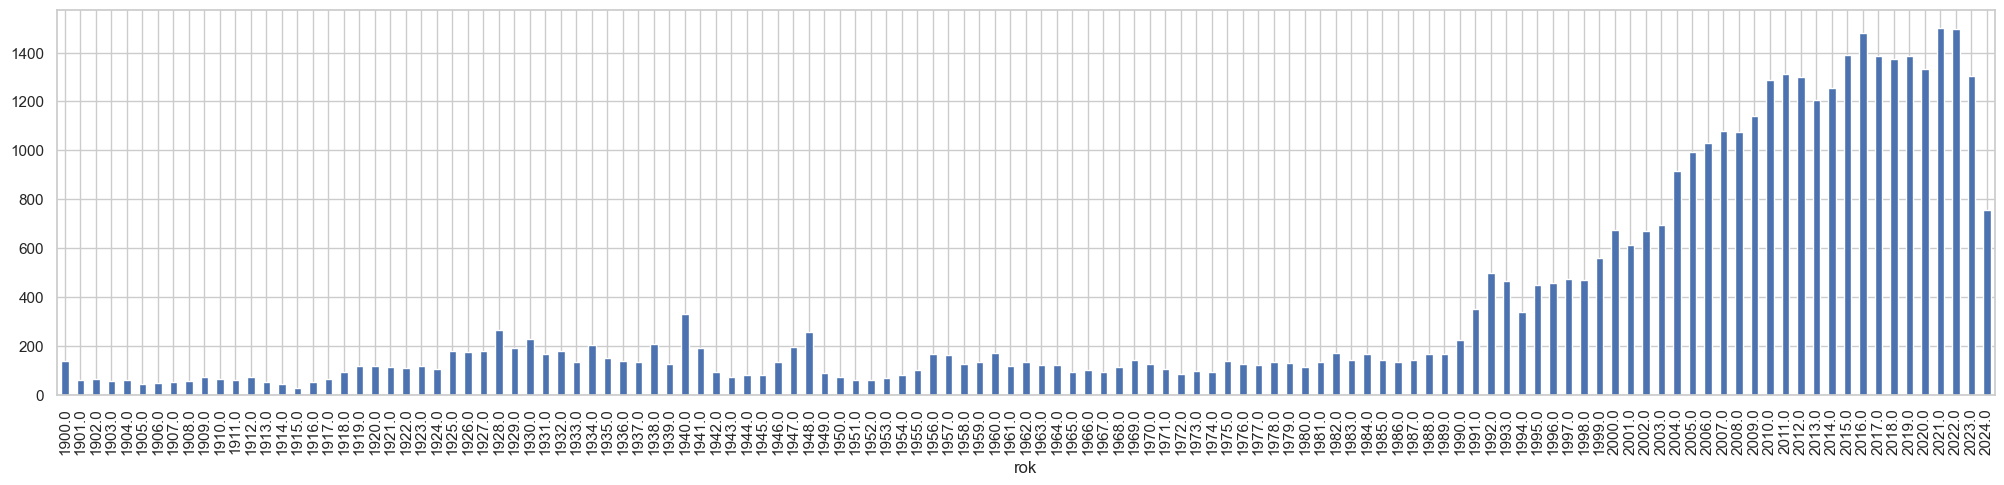

In [181]:
df.groupby('rok').size().plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

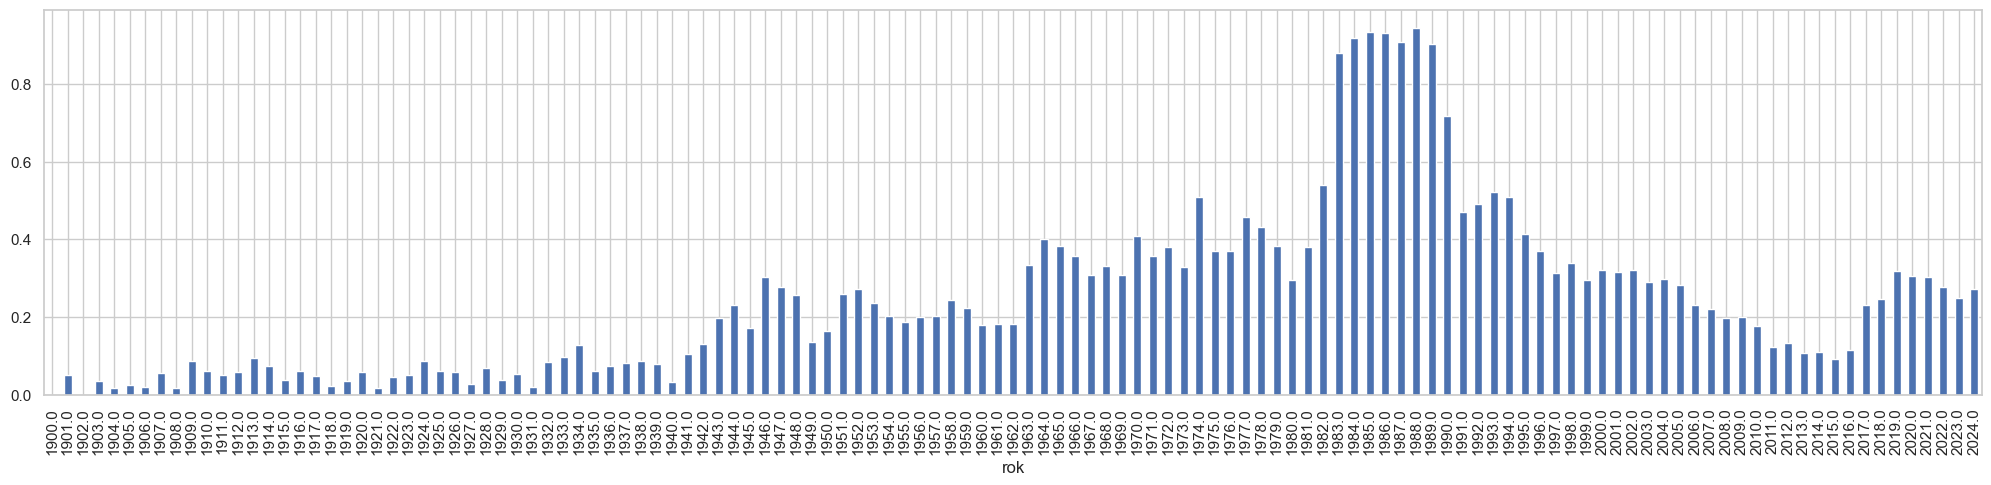

In [182]:
(df[df['cena'].notnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

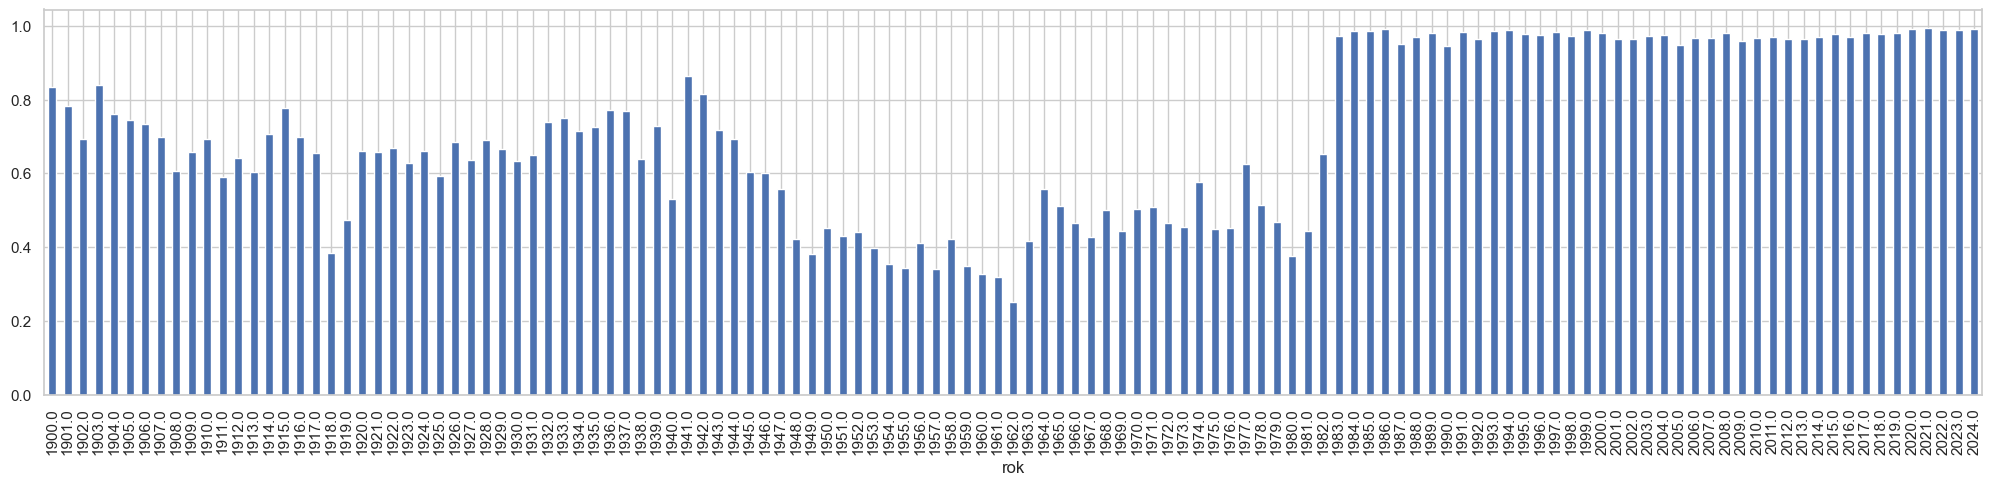

In [183]:
(df[df['vazba'].notnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

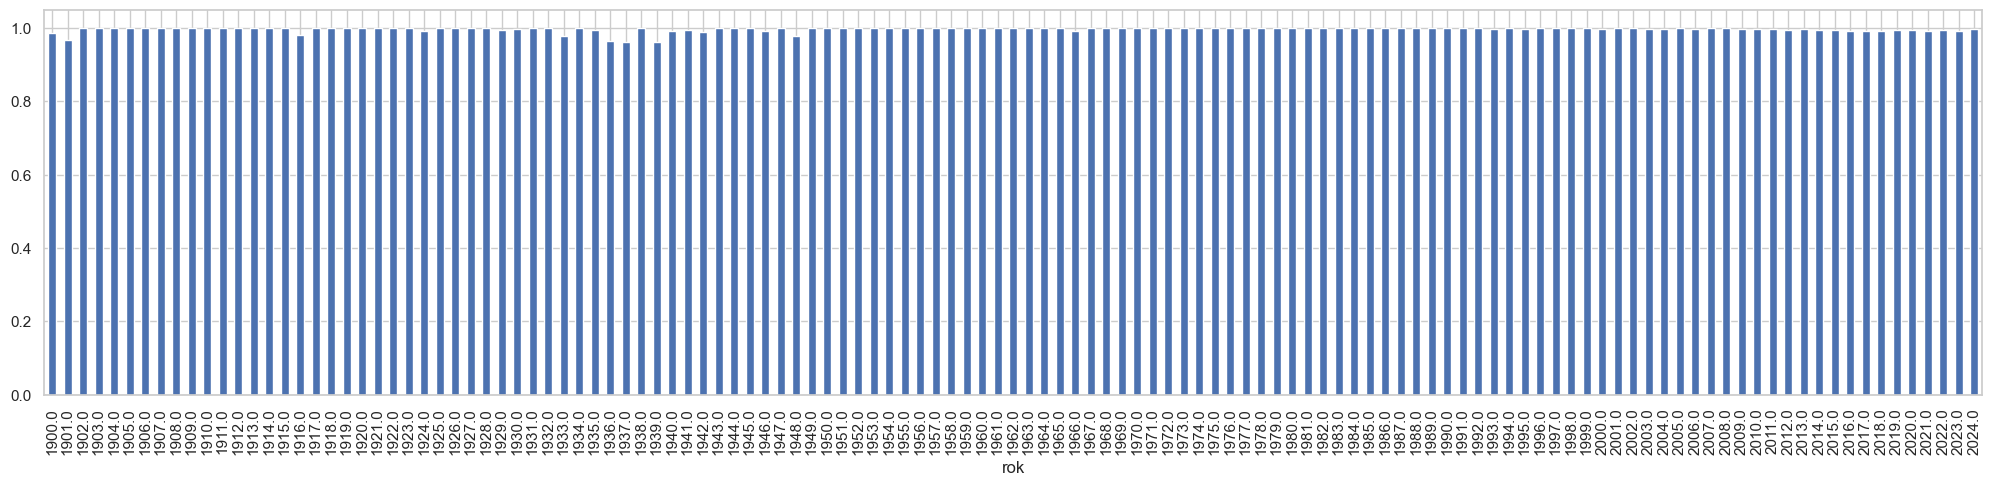

In [184]:
(df[df['stran'].notnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

## Explorace

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [187]:
df_grouped = df.groupby('rok')['stran'].agg([('median', 'median'), ('p25', lambda x: x.quantile(0.25)), ('p75', lambda x: x.quantile(0.75))]).reset_index()

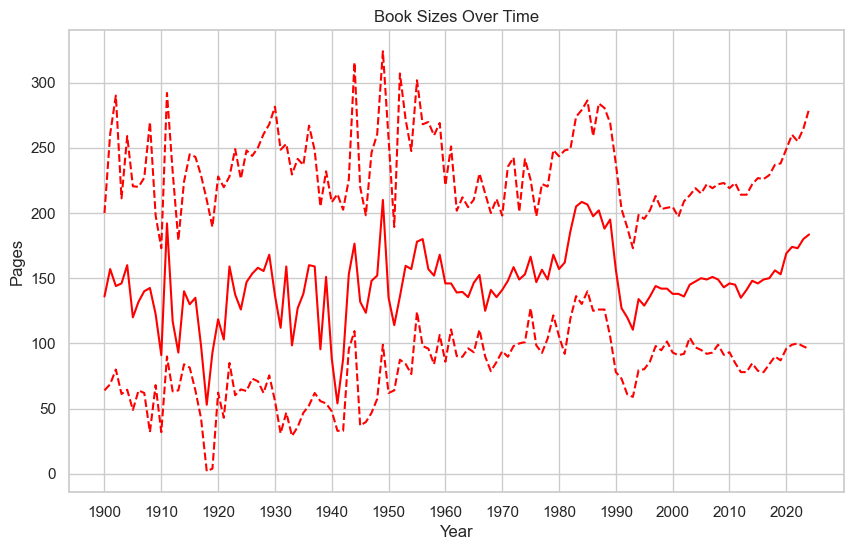

In [226]:
# Create a line plot
plt.figure(figsize=(10,6))
sns.lineplot(x='rok', y='stran', data=df, estimator='median', errorbar=None, color='red')

plt.plot(df_grouped['rok'], df_grouped['p25'], linestyle='dashed', label='25th Percentile', color='red')
plt.plot(df_grouped['rok'], df_grouped['p75'], linestyle='dashed', label='75th Percentile', color='red')

years = df_grouped['rok'].unique()
years_ending_with_0 = [year for year in years if year % 10 == 0]
plt.xticks(years_ending_with_0)

# Set the title and labels
plt.title('Book Sizes Over Time')
plt.xlabel('Year')
plt.ylabel('Pages')

# Show the plot
plt.show()

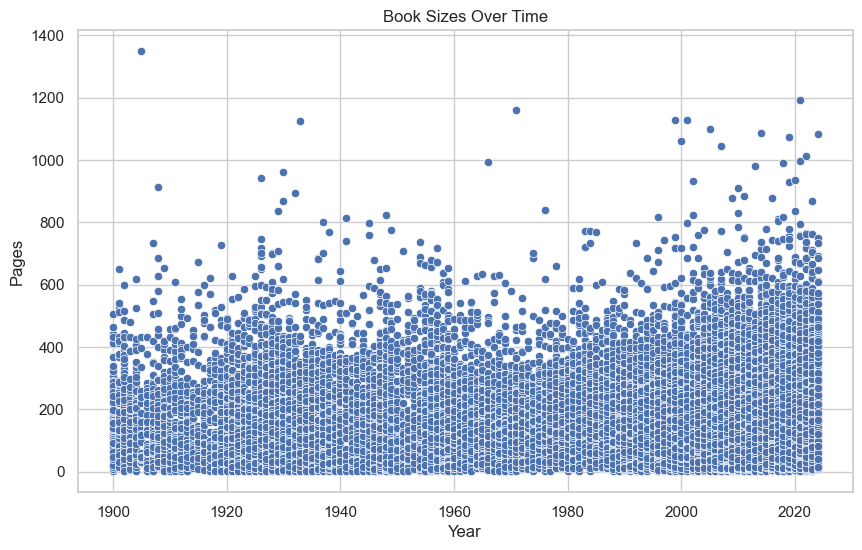

In [189]:
# Create a line plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='rok', y='stran', data=df)

# Set the title and labels
plt.title('Book Sizes Over Time')
plt.xlabel('Year')
plt.ylabel('Pages')

# Show the plot
plt.show()

<Axes: xlabel='rok'>

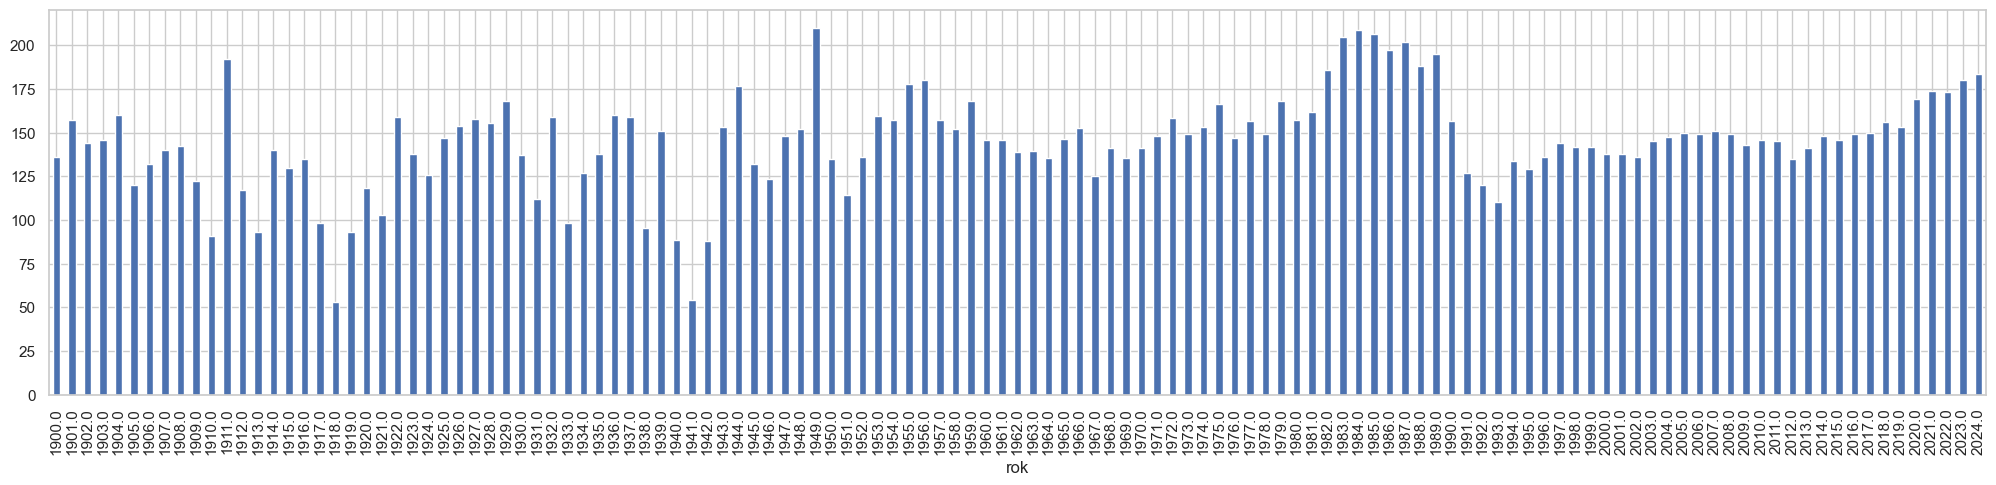

In [190]:
df.groupby("rok")['stran'].median().plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

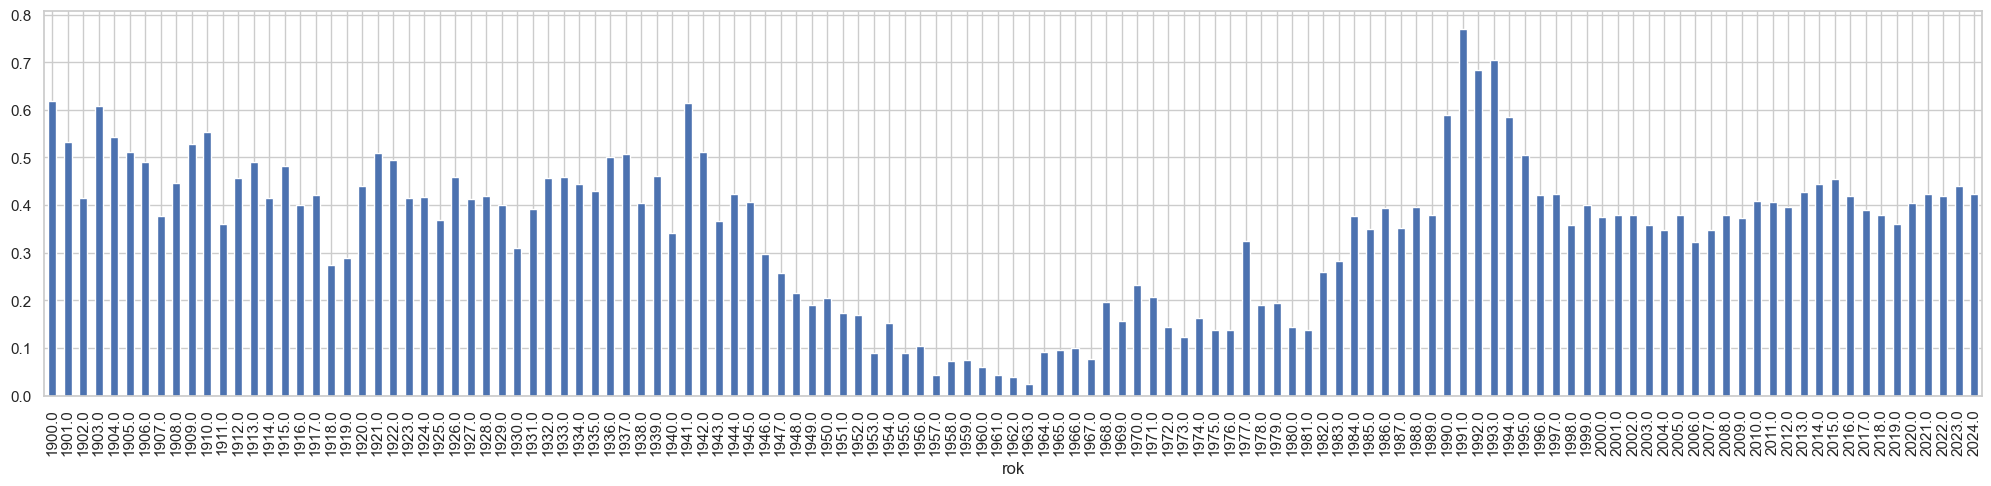

In [191]:
(df[df['vazba'] == 'brožovaná'].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

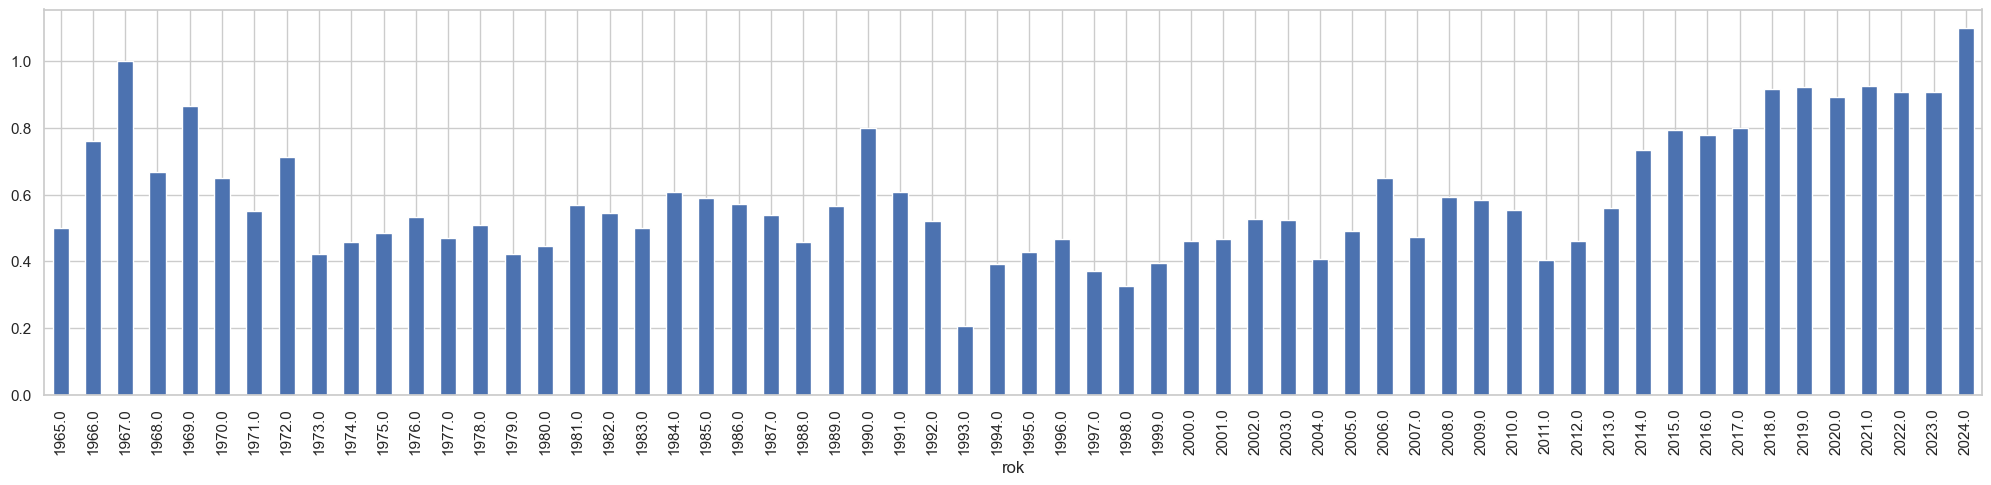

In [192]:
(df[df['vazba'] == 'brožovaná'].groupby('rok')['cena'].median() / df[df['vazba'] == 'pevná'].groupby('rok')['cena'].median()).tail(60).plot.bar(figsize=(25,5))